## Titanic Data

L'objectif est de prédire si un passager a survécu ou non sur la base d'attributs tels que son âge, son sexe, sa classe, le lieu de son embarquement, etc.

Allons chercher les données et les charger :

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Les données sont déjà divisées en un ensemble d'entraînement et un ensemble de test. Cependant, les données de test ne contiennent pas les étiquettes : votre objectif est de former le meilleur modèle possible en utilisant les données d'entraînement, puis de faire vos prédictions sur les données de test.

Jetons un coup d'œil aux premières lignes de l'ensemble de formation :

In [4]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Les attributs ont la signification suivante :
* **PassengerId**: un identifiant unique pour chaque passager
* **Survived**: c'est la cible, 0 signifie que le passager n'a pas survécu, tandis que 1 signifie qu'il a survécu.
* **Pclass**: la classe du passager.
* **Name**, **Sex**, **Age**: explicite
* **SibSp**: combien de frères et sœurs et de conjoints du passager à bord du Titanic.
* **Parch**: combien d'enfants et de parents des passagers à bord du Titanic.
* **Ticket**: id du ticket
* **Fare**: prix payé (en pounds)
* **Cabin**: numéro de cabine du passager
* **Embarked**: où le passager a embarqué sur le titanic

Définissons explicitement la colonne `PassengerId` comme colonne d'index :

In [5]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Obtenons plus d'informations pour voir combien de données manquent :

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

Bon, les attributs **Age**, **Cabin** et **Embarked** sont parfois nuls (moins de 891 non-nuls), surtout le **Cabin** (77% sont nuls). Nous allons ignorer la **Cabin** pour l'instant et nous concentrer sur le reste. L'attribut **Age** présente environ 19 % de valeurs nulles, nous devons donc décider ce que nous allons en faire. Remplacer les valeurs nulles par l'âge médian semble raisonnable. Nous pourrions être un peu plus malins en prédisant l'âge en fonction des autres colonnes (par exemple, l'âge médian est de 37 ans en 1ère classe, 29 ans en 2ème classe et 24 ans en 3ème classe), mais nous allons rester simples et utiliser l'âge médian global.

Les attributs **Name** et **Ticket** peuvent avoir une certaine valeur, mais ils seront un peu difficiles à convertir en chiffres utiles qu'un modèle pourra consommer. Pour l'instant, nous allons donc les ignorer.

Examinons les attributs numériques :

In [8]:
train_data.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699113    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526507    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.416700    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

* Oups, seulement 38% ont **survived** ! 😭 C'est assez proche de 40%, donc la précision sera une mesure raisonnable pour évaluer notre modèle.
* Le **Fare** moyen était de 32,20 £, ce qui ne semble pas si cher (mais c'était probablement beaucoup d'argent à l'époque).
* La moyenne **Age** était de moins de 30 ans.

Vérifions que la cible est bien 0 ou 1 :

In [9]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Maintenant, jetons un coup d'œil rapide à tous les attributs catégoriels :

In [10]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [12]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

L'attribut Embarked nous indique où le passager a embarqué : C=Cherbourg, Q=Queenstown, S=Southampton.

Construisons maintenant nos pipelines de prétraitement, en commençant par le pipeline pour les attributs numériques :

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Maintenant nous pouvons construire le pipeline pour les attributs catégoriels :

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

Enfin, rejoignons les pipelines numériques et catégoriels :

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Cool ! Nous disposons à présent d'un pipeline de prétraitement agréable qui prend les données brutes et produit des caractéristiques numériques d'entrée que nous pouvons intégrer à n'importe quel modèle d'apprentissage automatique.

In [17]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

N'oublions pas d'obtenir les étiquettes :

In [18]:
y_train = train_data["Survived"]

Nous sommes maintenant prêts à entraîner un classificateur. Commençons par un `RandomForestClassifier` :

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Super, notre modèle est entraîné, utilisons-le pour faire des prédictions sur l'ensemble de test :

In [20]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

Et maintenant nous pourrions simplement construire un fichier CSV avec ces prédictions (en respectant le format accepté par Kaggle), puis le télécharger et espérer le meilleur. Mais attendez ! Nous pouvons faire mieux qu'espérer. Pourquoi ne pas utiliser la validation croisée pour avoir une idée de la qualité de notre modèle ?

In [21]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

Okay, not too bad!

Essayons un `SVC` :

In [22]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Super ! Ce modèle a l'air mieux.

Mais au lieu de simplement regarder la précision moyenne à travers les 10 plis de validation croisée, nous allons tracer les 10 scores pour chaque modèle, avec un box plot mettant en évidence les quartiles inférieurs et supérieurs, et des "moustaches" montrant l'étendue des scores (merci à Nevin Yilmaz pour avoir suggéré cette visualisation). Notez que la fonction `boxplot()` détecte les valeurs aberrantes (appelées "fliers") et ne les inclut pas dans les moustaches. Plus précisément, si le quartile inférieur est $Q_1$ et le quartile supérieur est $Q_3$, alors l'écart interquartile $IQR = Q_3 - Q_1$ (c'est la hauteur de la boîte), et tout score inférieur à $Q_1 - 1,5 \times IQR$ est un flier, de même que tout score supérieur à $Q3 + 1,5 \times IQR$.

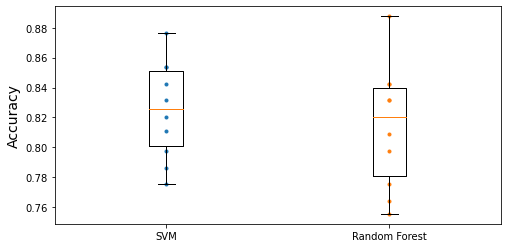

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Le classificateur forêt aléatoire a obtenu un score très élevé sur l'un des 10 plis, mais dans l'ensemble, il a obtenu un score moyen plus faible, ainsi qu'un écart plus important, il semble donc que le classificateur SVM soit plus susceptible de bien se généraliser.

Pour améliorer encore ce résultat, vous pourriez :
* Comparer beaucoup plus de modèles et régler les hyperparamètres en utilisant la validation croisée et la recherche sur grille,
* Faire plus d'ingénierie des caractéristiques, par exemple :
  * Essayer de convertir les attributs numériques en attributs catégoriels : par exemple, les différents groupes d'âge avaient des taux de survie très différents (voir ci-dessous), il peut donc être utile de créer une catégorie de seau d'âge et de l'utiliser à la place de l'âge. De même, il peut être utile d'avoir une catégorie spéciale pour les personnes voyageant seules puisque seulement 30% d'entre elles ont survécu (voir ci-dessous).
  * Remplacez **SibSp** et **Parch** par leur somme.
  * Essayez d'identifier les parties des noms qui correspondent bien à l'attribut **Survivant**.
  * Utilisez la colonne **Cabin**, par exemple prenez sa première lettre et traitez-la comme un attribut catégorique.

In [24]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

Survived
AgeBucket          
0.0        0.576923
15.0       0.362745
30.0       0.423256
45.0       0.404494
60.0       0.240000
75.0       1.000000

In [25]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

Survived
RelativesOnboard          
0                 0.303538
1                 0.552795
2                 0.578431
3                 0.724138
4                 0.200000
5                 0.136364
6                 0.333333
7                 0.000000
10                0.000000

In [67]:
#on créer un indice de richesse en partant en dividant le prix par la classe --> si on paye chere alors que l'on aurait pu payer moins chere on est plus riche
train_data["index_richesse"] = train_data["Fare"]/train_data["Pclass"]
#ne marche pas

In [68]:
train_data

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...                                                        ...     ...   ...   
887                                      Montvila, Rev. Juozas    male  27.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
889                   Johnston, Miss. Catherine Helen 'Carrie'  female   NaN   
890                                      Behr, Mr. Karl Howell    male  26.0   
891                                        Dooley, Mr. Patrick    male  32.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   
...            ...    ...               ...      ...   ...      ...   
887              0      0            211536  13.0000   NaN        S   
888              0      0            112053  30.0000   B42        S   
889              1      2        W./C. 6607  23.4500   NaN        S   
890              0      0            111369  30.0000  C148        C   
891              0      0            370376   7.7500   NaN        Q   

             AgeBucket  RelativesOnboard CabinDivision  index_richesse  
PassengerId                                                             
1                 15.0                 1           nan        2.416667  
2                 30.0                 1             C       71.283300  
3                 15.0                 0           nan        2.641667  
4                 30.0                 1             C       53.100000  
5                 30.0                 0           nan        2.683333  
...                ...               ...           ...             ...  
887               15.0                 0           nan        6.500000  
888               15.0                 0             B       30.000000  
889                NaN                 3           nan        7.816667  
890               15.0                 0             C       30.000000  
891               30.0                 0           nan        2.583333  

[891 rows x 15 columns]

Nous allons maintenant tester plusieur modèle afin de voir si on en trouve un plus efficace. 

In [26]:

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(X_train, y_train)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10)
dt_scores.mean()

0.7879151061173533

In [73]:
#on fait moins bien pour le decision tree
#je vais essayer d'implémenter les conseils de la correction
#on fait un age bucket 

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

num_attribs = ["Age","SibSp","Parch","RelativesOnboard","AgeBucket","Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [74]:
#on essaye de calculer le score pour le random forest et le SVM et le dt

forest_clf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf_2.fit(X_train, y_train)
forest_2_scores = cross_val_score(forest_clf_2, X_train, y_train, cv=10)
print("random forest = ",forest_2_scores.mean(),"avant = ",forest_scores.mean())

svm_clf_2 = SVC(gamma="auto")
svm_clf_2.fit(X_train, y_train)
svm_2_scores = cross_val_score(svm_clf_2, X_train, y_train, cv=10)
print("svm = ",svm_2_scores.mean(),"avant = ",svm_scores.mean())

dt_2 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_2.fit(X_train, y_train)
dt_2_scores = cross_val_score(dt_2, X_train, y_train, cv=10)
print("dt = ",dt_2_scores.mean(),"avant = ",dt_scores.mean())

random forest =  0.8081647940074905 avant =  0.8137578027465668
svm =  0.8305493133583021 avant =  0.8249313358302123
dt =  0.7923970037453183 avant =  0.7879151061173533


On remarque une augmentation du score pour le svm mais une baisse pour les autres

In [29]:
train_data

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...                                                        ...     ...   ...   
887                                      Montvila, Rev. Juozas    male  27.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
889                   Johnston, Miss. Catherine Helen 'Carrie'  female   NaN   
890                                      Behr, Mr. Karl Howell    male  26.0   
891                                        Dooley, Mr. Patrick    male  32.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   
...            ...    ...               ...      ...   ...      ...   
887              0      0            211536  13.0000   NaN        S   
888              0      0            112053  30.0000   B42        S   
889              1      2        W./C. 6607  23.4500   NaN        S   
890              0      0            111369  30.0000  C148        C   
891              0      0            370376   7.7500   NaN        Q   

             AgeBucket  RelativesOnboard  
PassengerId                               
1                 15.0                 1  
2                 30.0                 1  
3                 15.0                 0  
4                 30.0                 1  
5                 30.0                 0  
...                ...               ...  
887               15.0                 0  
888               15.0                 0  
889                NaN                 3  
890               15.0                 0  
891               30.0                 0  

[891 rows x 13 columns]

In [30]:
import numpy as np
cabD=[]
for cab in train_data["Cabin"]:
    if pd.isna(cab):
        cabD.append("nan")
    else :
        cabD.append(cab[0])

train_data["CabinDivision"]=pd.Series(cabD).set_axis(range(1,len(cabD)+1))

In [31]:
train_data.head(50)

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
6                   0       3   
7                   0       1   
8                   0       3   
9                   1       3   
10                  1       2   
11                  1       3   
12                  1       1   
13                  0       3   
14                  0       3   
15                  0       3   
16                  1       2   
17                  0       3   
18                  1       2   
19                  0       3   
20                  1       3   
21                  0       2   
22                  1       2   
23                  1       3   
24                  1       1   
25                  0       3   
26                  1       3   
27                  0       3   
28                  0       1   
29                  1       3   
30                  0       3   
31                  0       1   
32                  1       1   
33                  1       3   
34                  0       2   
35                  0       1   
36                  0       1   
37                  1       3   
38                  0       3   
39                  0       3   
40                  1       3   
41                  0       3   
42                  0       2   
43                  0       3   
44                  1       2   
45                  1       3   
46                  0       3   
47                  0       3   
48                  1       3   
49                  0       3   
50                  0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
6                                             Moran, Mr. James    male   NaN   
7                                      McCarthy, Mr. Timothy J    male  54.0   
8                               Palsson, Master. Gosta Leonard    male   2.0   
9            Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0   
10                         Nasser, Mrs. Nicholas (Adele Achem)  female  14.0   
11                             Sandstrom, Miss. Marguerite Rut  female   4.0   
12                                    Bonnell, Miss. Elizabeth  female  58.0   
13                              Saundercock, Mr. William Henry    male  20.0   
14                                 Andersson, Mr. Anders Johan    male  39.0   
15                        Vestrom, Miss. Hulda Amanda Adolfina  female  14.0   
16                             Hewlett, Mrs. (Mary D Kingcome)  female  55.0   
17                                        Rice, Master. Eugene    male   2.0   
18                                Williams, Mr. Charles Eugene    male   NaN   
19           Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0   
20                                     Masselmani, Mrs. Fatima  female   NaN   
21                                        Fynney, Mr. Joseph J    male  35.0   
22                                       Beesley, Mr. Lawrence    male  34.0   
23                                 McGowan, Miss. Anna 'Annie'  female  15.0   
24                                Sloper, Mr. William Thompson    male  28.0   
25                               Palsson, Miss. Torborg Danira  female   8.0   
26           Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0   
27                                     Emir, Mr. Farred 

In [32]:
num_attribs = ["Age", "SibSp", "RelativesOnboard","AgeBucket"]
cat_attribs = ["Pclass", "Sex", "Embarked","CabinDivision"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573582,  0.43279337,  0.05915988, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337,  0.05915988, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.56097483, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  1.29942929, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.56097483, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.56097483, ...,  0.        ,
         0.        ,  1.        ]])

In [33]:
#on essaye de calculer le score pour le random forest et le SVM et le dt

forest_clf_3 = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf_3.fit(X_train, y_train)
forest_3_scores = cross_val_score(forest_clf_3, X_train, y_train, cv=10)
print("random forest = ",forest_3_scores.mean(),"avant = ",forest_scores.mean())

svm_clf_3 = SVC(gamma="auto")
svm_clf_3.fit(X_train, y_train)
svm_3_scores = cross_val_score(svm_clf_2, X_train, y_train, cv=10)
print("svm = ",svm_3_scores.mean(),"avant = ",svm_scores.mean())

dt_3 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_3.fit(X_train, y_train)
dt_3_scores = cross_val_score(dt_3, X_train, y_train, cv=10)
print("dt = ",dt_3_scores.mean(),"avant = ",dt_scores.mean())

random forest =  0.8093008739076154 avant =  0.8137578027465668
svm =  0.8204244694132334 avant =  0.8249313358302123
dt =  0.7946691635455679 avant =  0.7879151061173533


on fait moins bien sauf pour le decision tree (probablement à cause du faite que beaucoup de valeur sont en NAN)

On fait une prédiction en suivant le modèle svm avec le age bucket et les différents conseils de la correction

In [37]:
#on créer un age bucket à propos pour les données de test et on fait le nouveau feature relative on board 
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]
test_data["AgeBucket"] = test_data["Age"] // 15 * 15
test_data

Pclass                                          Name     Sex  \
PassengerId                                                                 
892               3                              Kelly, Mr. James    male   
893               3              Wilkes, Mrs. James (Ellen Needs)  female   
894               2                     Myles, Mr. Thomas Francis    male   
895               3                              Wirz, Mr. Albert    male   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
...             ...                                           ...     ...   
1305              3                            Spector, Mr. Woolf    male   
1306              1                  Oliva y Ocana, Dona. Fermina  female   
1307              3                  Saether, Mr. Simon Sivertsen    male   
1308              3                           Ware, Mr. Frederick    male   
1309              3                      Peter, Master. Michael J    male   

              Age  SibSp  Parch              Ticket      Fare Cabin Embarked  \
PassengerId                                                                    
892          34.5      0      0              330911    7.8292   NaN        Q   
893          47.0      1      0              363272    7.0000   NaN        S   
894          62.0      0      0              240276    9.6875   NaN        Q   
895          27.0      0      0              315154    8.6625   NaN        S   
896          22.0      1      1             3101298   12.2875   NaN        S   
...           ...    ...    ...                 ...       ...   ...      ...   
1305          NaN      0      0           A.5. 3236    8.0500   NaN        S   
1306         39.0      0      0            PC 17758  108.9000  C105        C   
1307         38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S   
1308          NaN      0      0              359309    8.0500   NaN        S   
1309          NaN      1      1                2668   22.3583   NaN        C   

             RelativesOnboard  AgeBucket  
PassengerId                               
892                         0       30.0  
893                         1       45.0  
894                         0       60.0  
895                         0       15.0  
896                         2       15.0  
...                       ...        ...  
1305                        0        NaN  
1306                        0       30.0  
1307                        0       30.0  
1308                        0        NaN  
1309                        2        NaN  

[418 rows x 12 columns]

In [75]:
num_attribs = ["Age","SibSp","Parch","RelativesOnboard","AgeBucket","Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])

In [77]:
y_test=svm_clf_2.predict(X_test)

In [84]:
y_test_df=pd.DataFrame(y_test, columns = ['survived'])

In [94]:
y_test_df.index.names = ['PassengerId']
y_test_df.head(20)

survived
PassengerId          
892                 0
893                 1
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 1
911                 1

In [96]:
y_test_df.to_csv("C:/Users/miaou/Documents/UTT/ISI-2/PE_IA_RM/Python_script/titanic_competition/datasets/titanic/y_test.csv")